In [2]:
import torch
import torchvision

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
len(dataset)

60000

In [5]:
img, label = dataset[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

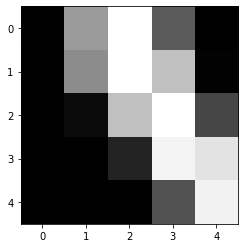

In [6]:
plt.imshow(img[0],cmap='gray')
plt.imshow(img[0,10:15,10:15],cmap='gray')

Use `random_split` to split our dataset into training and validation sets. We will do an 80%-20% split.

In [12]:
val_pct = 0.2
val_size = int(val_pct*len(dataset))
train_size = int(len(dataset) - val_size)

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(48000, 12000)

Create PyTorch data loaders for training and validation.

In [13]:
batch_size = 128

train_loader = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


For arguments `num_workers` and `pin_memory` Documentation: https://pytorch.org/docs/stable/data.html .

We can visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


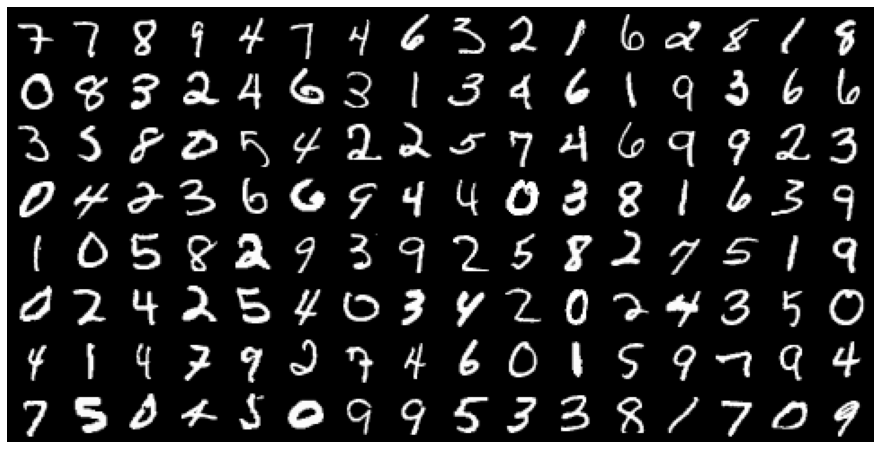

In [14]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a _hidden layer_ and an _output layer_. Additionally, we'll use an _activation function_ between the two layers. Hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

Let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [15]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Now, let's create a `nn.Linear` object, which will serve as our _hidden_ layer. We'll set the size of the output from the hidden layer to 32. 

This number can be increased or decreased to change the _learning capacity_ of the model.

In [19]:
input_size = inputs.shape[-1]
hidden_size = 32

784


In [20]:
layer1 = nn.Linear(input_size, hidden_size)

Intermediate outputs for the batch of images can be computed by passing `inputs` through `layer1`.

In [21]:
layer1_outputs = layer1(inputs)
print(f'layer1 Output Shape: {layer1_outputs.shape}')

layer1 Output Shape: torch.Size([128, 32])


Image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of `inputs` matrix with the transposed weights matrix of `layer1` and adding the bias. We can verify this using `torch.allclose`.

In [22]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

Now to verify that these outputs, obtained by direct matrix multiplication and addition of biases are equal to layer1 outputs, we use `.allclose` method.

In [23]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

So, `layer1_outputs` and `inputs` have a linear relationship.

Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between inputs and outputs.

### Activation Function
We'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs.

 It is given by, relu(x) = max(0,x) i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function - 0 for all x<0, and linear with slope 1 for all x>0

In [24]:
# Example
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

We will apply ReLU activation `layer1_outputs` and verify that negative values are replaced with 0.

In [25]:
relu_outputs = F.relu(layer1_outputs)
print('Minimum of layer1 outputs: ', torch.min(layer1_outputs).item())
print('Minimum after ReLU:', torch.min(relu_outputs).item())

Minimum of layer1 outputs:  -0.9675878882408142
Minimum after ReLU: 0.0


Sinze we have applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship.

Now, create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10 (number of output classes we have).

In [26]:
output_size = 10
layer2 = nn.Linear(hidden_size,output_size)

In [27]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [28]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.2906, grad_fn=<NllLossBackward>)

Our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`), followed by a non-linear activation (using `F.relu`), followed by another linear transformation (using `layer2`). Let's verify this by re-computing the output using basic matrix operations.

In [30]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias
torch.allclose(outputs,layer2_outputs,1e-3)

True

Therefore, we can now train our model and capture non-linear relationship between inputs and outputs, making our model powerful and versatile.

This is how we create a Neural Network. A DNN is a neural network with one or more hidden layers. 

## Model

We now define our model. We'll create a neural network with one hidden layer.

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* (ReLU) to the intermediate outputs. The activation function transforms individual elements of the matrix by a non-linear relationship.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.

\\
Let's define the model by extending the `nn.Module` class from PyTorch.

In [31]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We also need to define an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` above.

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [34]:
input_size = 784
hidden_size = 32 # Can be changed
num_classes = 10

In [35]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

We can look at the models' parameters. We expect to see one weight and bias matrix for each of the layers.

In [36]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


We'll take the first batch of 128 images from our dataset and pass them into our model.

In [37]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('Outputs Shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 2.29430890083313
Outputs Shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0478,  0.1148,  0.0280, -0.0111,  0.0217,  0.0422, -0.0102,  0.0097,
         -0.2092,  0.1039],
        [ 0.0153,  0.1301,  0.1549, -0.2203, -0.0288,  0.2316, -0.0691,  0.2869,
         -0.0436,  0.0404]])


We need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. 

For turning on GPU in Colab: Runtime -> Change Runtime Type -> Hardware accelerator -> GPU

We can check if a GPU is available and if the required NVIDIA CUDA drivers are installed, using `torch.cuda.is_available`.

In [38]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't. 

In [39]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [40]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device.

In [41]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [42]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
cuda:0


We define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device.

We don't need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [43]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

The `yield` keyword in Python is used to create a generator function that can be used within a `for` loop. Example is shown below:

In [44]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


We can now wrap our data loaders using `DeviceDataLoader`.

In [45]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors moved to the GPU have a `device` property which includes the word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [46]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


xb.device: cuda:0
yb: tensor([4, 0, 3, 7, 3, 7, 1, 7, 7, 4, 7, 2, 4, 0, 1, 6, 2, 3, 7, 2, 0, 2, 8, 8,
        4, 3, 2, 5, 9, 2, 0, 5, 6, 7, 0, 1, 8, 6, 4, 4, 4, 8, 3, 5, 3, 3, 6, 4,
        7, 5, 7, 1, 9, 0, 2, 3, 8, 2, 0, 6, 0, 1, 1, 0, 8, 2, 1, 2, 3, 9, 0, 6,
        6, 7, 2, 3, 2, 0, 0, 7, 1, 1, 2, 2, 3, 3, 3, 8, 9, 0, 9, 3, 4, 4, 5, 7,
        5, 6, 4, 4, 9, 1, 2, 3, 6, 7, 4, 0, 9, 1, 6, 9, 0, 1, 1, 9, 6, 6, 9, 4,
        0, 8, 2, 8, 4, 5, 6, 9, 6, 2, 6, 3, 2, 3, 3, 2, 5, 6, 5, 2, 6, 1, 6, 9,
        2, 0, 1, 3, 4, 5, 2, 3, 6, 1, 0, 3, 7, 8, 2, 4, 6, 7, 3, 5, 6, 4, 4, 7,
        1, 1, 1, 9, 8, 5, 4, 2, 3, 4, 4, 4, 4, 2, 6, 7, 4, 8, 4, 0, 7, 7, 8, 8,
        5, 1, 1, 1, 9, 8, 7, 8, 4, 7, 6, 5, 5, 9, 7, 0, 7, 8, 8, 6, 6, 6, 3, 0,
        4, 9, 4, 7, 9, 1, 0, 0, 0, 2, 7, 0, 1, 3, 3, 4, 0, 5, 7, 1, 1, 0, 0, 9,
        0, 4, 6, 8, 7, 8, 2, 3, 6, 2, 5, 7, 6, 2, 4, 0], device='cuda:0')


## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set.

In [47]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [48]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Check how the model performs on the validation set with the initial random set of weights and biases.

In [49]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.10958871245384216, 'val_loss': 2.3095381259918213}]

Let us train for 5 epochs. We will use a learning rate of 0.5 (which is relatively high).

In [50]:
history += fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.2248, val_acc: 0.9334
Epoch [1], val_loss: 0.1907, val_acc: 0.9454
Epoch [2], val_loss: 0.1657, val_acc: 0.9498
Epoch [3], val_loss: 0.1455, val_acc: 0.9567
Epoch [4], val_loss: 0.1537, val_acc: 0.9528


Let's train the model for five more epochs at a lower learning rate of 0.1 to improve the accuracy further.

In [51]:
history += fit(5, 0.1, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.1277, val_acc: 0.9614
Epoch [1], val_loss: 0.1252, val_acc: 0.9627
Epoch [2], val_loss: 0.1242, val_acc: 0.9627
Epoch [3], val_loss: 0.1245, val_acc: 0.9620
Epoch [4], val_loss: 0.1229, val_acc: 0.9624


Let's plot the losses & accuracies to see how the model improves over time.

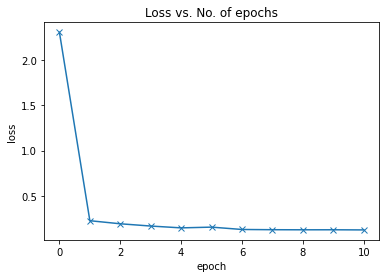

In [52]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

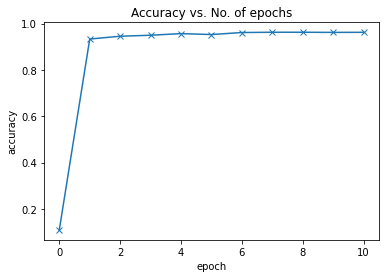

In [53]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Clearly, by introducing non-linearity, we have improved our model compared to that trained using Logistic Regression. 

To improve accuracy even further, we need to make the model more powerful by increasing the hidden layer's size or adding more hidden layers with activations. 

## Testing

Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [54]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [55]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


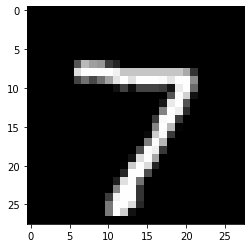

In [56]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


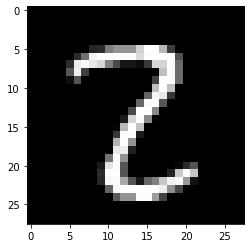

In [57]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

The above image was predicted as '8' in the previous Logistic Regression model.

Label: 9 , Predicted: 9


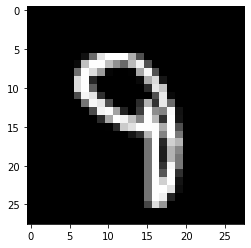

In [58]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Let's look at the overall loss and accuracy of the model on the test set.

In [59]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9698241949081421, 'val_loss': 0.1035781130194664}

#### Save the model

In [60]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')